In [1]:
#Library imports
import re
import os
import sys
import shutil
import time
import math
import fnmatch
import random
import warnings
import numpy as np
import pandas as pd
import scipy.stats as scs
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy.stats as scs

import fiona
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon, LineString
from pyproj import Proj
import geoplot as gplt
import geoplot.crs as gcrs


from sklearn.neighbors import BallTree

# Allows access to scripts and modules relative to the parent directory.
parent = os.getcwd()
sys.path.append(os.path.join(parent, "functions"))

# Project specific user driven functions
from cleaning_functions import *
from eda_functions import *

# My open source reusable user driven function repository.
from random_lumberjacks.src.random_lumberjacks.cleaning.cleaning_functions import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
water_final = pd.read_csv("data/Water_FINAL.csv", low_memory = False)
water_dict = pd.read_csv("data/CBP_water_dictionary_final.csv")

In [3]:
water_final.head()

,Unnamed: 0,Unnamed: 0.1,Agency,BiasPC,CloudCover,Comments,Cruise,Database,Date,FieldActivityEventType,...,Weather Conditions Yesterday,WindDirection,WindSpeed,state,Point,HUC12_,HUCNAME_,FIPS_,COUNTY_,STATE_
0,0,2143,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,W,1-10 knots,MD,POINT (-75.93002800000002 39.480194),20600020206,Bohemia River,24015,Cecil County,MD
1,1,2145,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,W,1-10 knots,MD,POINT (-75.902528 39.480444),20600020206,Bohemia River,24015,Cecil County,MD
2,2,2147,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,S,1-10 knots,MD,POINT (-75.873639 39.466889),20600020206,Bohemia River,24015,Cecil County,MD
3,3,2151,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,SW,1-10 knots,MD,POINT (-75.854444 39.454),20600020206,Bohemia River,24015,Cecil County,MD
4,4,2152,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,SW,1-10 knots,MD,POINT (-75.84352800000001 39.463667),20600020206,Bohemia River,24015,Cecil County,MD


In [4]:
def preliminary_cleaning(orig_df):
    
    df = orig_df.copy()
    # Combining the Date and Time parameters into a single Datetime Object
    df["Date"] = df["Date"]+"-"+df["Time"]
    df["Date"] = pd.to_datetime(df["Date"])
    
    # The Station identifiers are unique between the two datasets so they can be merged into a single column.
    df['Station'] = np.where(df['Station'].isnull(), df['StationCode'], df['Station'])
    
    # It will be easier to compare observed tide data by combining them into the same column first.
    df["Tidal Stage"] = df["Tidal Stage"].map(standardize_CMC_tidal_strings)
    df['TideStage'] = np.where(df['TideStage'].isnull(), df['Tidal Stage'], df['TideStage'])
    
    # Regex cleanup of weather conditions field.
    df["Weather Conditions Today"]=df["Weather Conditions Today"].map(standardize_CMC_weather_strings)
    df["Weather Conditions Yesterday"]=df["Weather Conditions Yesterday"].map(standardize_CMC_weather_strings)
    
    # Regex cleanup of wind speed field.
    df["WindSpeed"] = df["WindSpeed"].map(standardize_CMC_wind_strings)
    
    # Case cleaning of the Wind Direction Field.
    df["WindDirection"] = df["WindDirection"].map(standardize_CMC_wind_dir_strings)
    
    # Regex cleanup of the Water Surfaces field
    df["Water Surfaces"] = df["Water Surfaces"].map(standardize_CMC_water_surf_strings)
    
    # Dropping indexes, redundancies, and qualitative data that won't be used in model.
    df.drop(columns = ["Unnamed: 0", "Unnamed: 0.1", "FieldActivityRemark", "PrecisionPC", "Comments",
                       "Time", "Other Comments", "Other Conditions", "StationCode", "StationName",
                       "Tidal Stage", "ModifiedDate", "Water Color", "Water Color Description",
                       "Water Odor", "Water Odor Description", "state", 'COUNTY_', 'STATE_', "Lab",
                       "BiasPC"], inplace=True)
    
    # Reducing observations to parameters for model
    df = df[(df["ParameterName_CBP"]=="WATER TEMPERATURE DEG") | (df["ParameterName_CBP"]=="SPECIFIC CONDUCTIVITY") |
        (df["ParameterName_CBP"]=="AIR TEMPERATURE DEG")]
    
    return df
df = preliminary_cleaning(water_final)

Before flattening and removing columns, the following user created functions make it easy to determine whether
maintining the parameter subgroups is worth the complexity it will introduce.

In [5]:
full_value_comparison(df, "ParameterName_CBP", "Parameter")

WATER TEMPERATURE DEG
There are 13 unique values with 0 nan values making up 0.0%
388565-WTEMP --90.23%
11760-WT.3 --2.73%
8763-WT.10 --2.03%
4616-WT.4 --1.07%
4299-WT.1 --1.00%
4151-WT.2 --0.96%
3673-WT.6 --0.85%
2351-WT.13 --0.55%
751-WT.9 --0.17%
723-WT.8 --0.17%
602-WT.12 --0.14%
355-WT.5 --0.08%
29-WT.7 --0.01%

SPECIFIC CONDUCTIVITY
There are 6 unique values with 0 nan values making up 0.0%
11794-CO.1 --54.34%
4634-CO.5 --21.35%
2978-CO.8 --13.72%
2068-CO.4 --9.53%
150-CO.9 --0.69%
82-CO.2 --0.38%

AIR TEMPERATURE DEG
There are 9 unique values with 0 nan values making up 0.0%
4802-AT.6 --28.71%
4072-AT.2 --24.35%
2258-AT.1 --13.50%
1808-AT.3 --10.81%
1794-AT.10 --10.73%
776-AT.9 --4.64%
725-AT.4 --4.34%
364-AT.5 --2.18%
125-AT.11 --0.75%



Aside from a string formatting discrepancy, 4 units are shared across the 3 main groups of parameters. They are distinct enough to identify that the conductivity values have two possible units.

In [6]:
full_value_counts(df, "Unit")

There are 4 unique values with 0 nan values making up 0.0%
388565-DEG C --82.84%
58797-deg C --12.53%
21624-uS/cm --4.61%
82-mS/cm --0.02%


It is already defined in the CO.2 (conductivity) parameter which will need to be converted to match the rest
of the data.

In [7]:
df[df["Unit"]=="mS/cm"]["Parameter"].equals(df[df["Parameter"]=="CO.2"]["Parameter"])

True

Converting it to the the proper units shows an enormous effect size between the two groups. Without more information,

In [8]:
(df[df["Parameter"]=="CO.2"]["MeasureValue"]*1000).describe()

count       82.000000
mean      9729.512195
std       2311.539438
min       6950.000000
25%       8060.000000
50%       8770.000000
75%      12565.000000
max      13900.000000
Name: MeasureValue, dtype: float64

In [9]:
df[(df["Parameter"]!="CO.2") & (df["ParameterName_CBP"]=="SPECIFIC CONDUCTIVITY")]["MeasureValue"].describe()

count    21624.000000
mean       248.263076
std        398.445798
min          0.030000
25%         47.537500
50%        153.000000
75%        318.000000
max      15449.000000
Name: MeasureValue, dtype: float64

In [10]:
df[df["Parameter"]=="CO.2"][["Date", "Database", "Station", "Latitude", "Longitude"]].set_index("Date")

,Database,Station,Latitude,Longitude
Date,,,,
2018-05-03 08:36:00,CMC,SCC.MAC,38.9732,-76.4924
2018-05-03 08:36:00,CMC,SCC.MAC,38.9732,-76.4924
2018-05-03 08:36:00,CMC,SCC.MAC,38.9732,-76.4924
2018-05-03 08:46:00,CMC,SCC.SUP,38.9724,-76.4893
2018-05-03 08:46:00,CMC,SCC.SUP,38.9724,-76.4893
...,...,...,...,...
2018-05-31 09:33:00,CMC,SCC.EYC,38.9753,-76.4782
2018-05-31 09:33:00,CMC,SCC.EYC,38.9753,-76.4782
2018-05-31 09:49:00,CMC,SCC.MOS,38.9753,-76.4837


In [11]:
full_value_counts(df[df["Parameter"]=="CO.2"], "Station")

There are 9 unique values with 0 nan values making up 0.0%
10-SCC.HC --12.20%
9-SCC.MSW --10.98%
9-SCC.MSM --10.98%
9-SCC.HW --10.98%
9-SCC.EYC --10.98%
9-SCC.MOS --10.98%
9-SCC.MOWC --10.98%
9-SCC.SUP --10.98%
9-SCC.MAC --10.98%


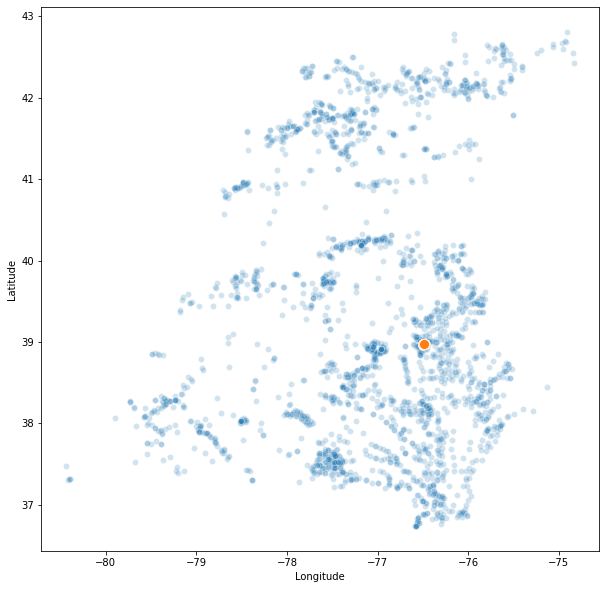

In [12]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="Longitude", y="Latitude", data=df[df["Parameter"]!="CO.2"].groupby("Station").first(), alpha=.2)
sns.scatterplot(x="Longitude", y="Latitude", data=df[df["Parameter"]=="CO.2"].groupby("Station").first(), **{"s":100})


The tiny point on the map(after scaling for visibility) indicates that these samples are in very close proximity to each other, compared to the rest of the data. Further investigation revealed the closest points having much different values, but they weren't that close comparatively. It may be worth revisiting to improve the model later.

In [13]:
df[df["Parameter"]=="CO.2"]["MeasureValue"] *= 1000

/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
def unnest_cmc_cbp_dataframe(data):

    df = data.copy()
    # Prior unit conversion
    df["MeasureValue"] = np.where(df['Parameter'] == "CO.2", df["MeasureValue"] * 1000, df["MeasureValue"])

    # Creating new columns to break out the nested measurements
    for new_col in df["ParameterName_CBP"].unique():
        df[new_col] = np.where(df['ParameterName_CBP'] == new_col, df["MeasureValue"], np.nan)

    # Removing the original columns.
    df.drop(columns = ["Parameter", "ParameterName_CMC", "ParameterName_CBP", 'MeasureValue', 'Unit'], inplace=True)
    
    # Reduces observations to the interval of the target variable
    df = extract_timespan(df, "Date", "SPECIFIC CONDUCTIVITY")

    # Using these three values in a groupby, the dataframe will be tightened a bit without loss.
    groups = ["Date", "Station", "SampleDepth"]

    # Prevents Missing Sample Depth From Being dropped.
    df["SampleDepth"] = df["SampleDepth"].fillna(-999)

    # Flattens overlapping data removing nans
    df = df.groupby(groups).first().reset_index()

    #Returns sample depth back to original nans.
    df["SampleDepth"] = np.where(df["SampleDepth"]==-999, np.nan, df["SampleDepth"])
    
    return df

df = unnest_cmc_cbp_dataframe(df)

Upon examining the data for water temperature, the histogram indicates a major outlier.

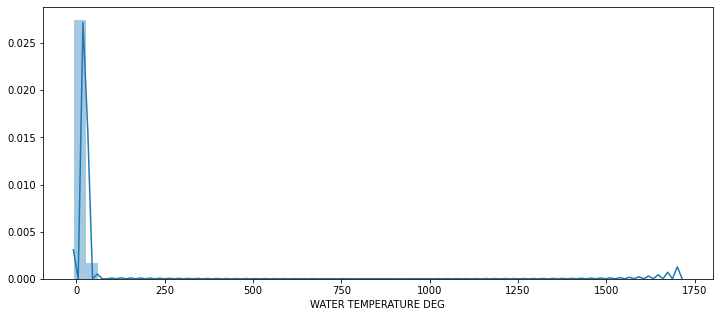

In [15]:
plt.figure(figsize=(12,5))
sns.distplot(df["WATER TEMPERATURE DEG"])

Further examination from anything that could be unusually high revealed what seems to be mistakes from wrong temperature units and missing decimals.

In [16]:
df[df["WATER TEMPERATURE DEG"]> 42][["Database", "Method", "Date", "SampleDepth", "Station", "WATER TEMPERATURE DEG"]]

,Database,Method,Date,SampleDepth,Station,WATER TEMPERATURE DEG
12298,CBP,F01,2005-10-24 12:05:00,0.5,XGG9992,55.8
14733,CBP,F01,2005-12-12 08:39:00,0.5,ET4.1,47.0
14734,CBP,F01,2005-12-12 08:39:00,1.0,ET4.1,48.0
14735,CBP,F01,2005-12-12 08:39:00,2.0,ET4.1,45.0
14736,CBP,F01,2005-12-12 08:39:00,3.0,ET4.1,45.0
14737,CBP,F01,2005-12-12 08:39:00,4.0,ET4.1,45.0
14738,CBP,F01,2005-12-12 08:39:00,4.9,ET4.1,47.0
14739,CBP,F01,2005-12-12 08:39:00,5.0,ET4.1,47.0
55976,CMC,NaN,2007-05-08 12:00:00,0.3,LCCD.MILL2,68.0
63823,CMC,NaN,2007-07-09 12:00:00,0.3,LCCD.MILL2,77.0


Examining the adjacent temperature readings of the biggest outlier confirms the missing decimal point.

In [17]:
mbj004 = df[df["Station"]=="MJB004.30"].set_index("Date").reset_index()
mbj004[mbj004["Date"]=="2010-04-13 09:18:00"][["Database", "Method", "Date", "SampleDepth", "Station", "WATER TEMPERATURE DEG"]]

,Database,Method,Date,SampleDepth,Station,WATER TEMPERATURE DEG
6,CBP,F01,2010-04-13 09:18:00,1.0,MJB004.30,17.13
7,CBP,F01,2010-04-13 09:18:00,2.0,MJB004.30,17.12
8,CBP,F01,2010-04-13 09:18:00,3.0,MJB004.30,1712.00
9,CBP,F01,2010-04-13 09:18:00,4.0,MJB004.30,16.96
10,CBP,F01,2010-04-13 09:18:00,5.0,MJB004.30,16.82
11,CBP,F01,2010-04-13 09:18:00,6.0,MJB004.30,16.83


The monthly averages converted to Fahrenheit are a strong match for the readings above 40C.

In [18]:
month_avg = df.copy()
month_avg["WATER TEMPERATURE DEG"] = np.where(month_avg["WATER TEMPERATURE DEG"] == 1712.00, 17.12, month_avg["WATER TEMPERATURE DEG"])
month_avg["Month"] = pd.DatetimeIndex(month_avg["Date"]).month
month_avg.groupby("Month")["WATER TEMPERATURE DEG"].mean()*9/5+32

Month
1     40.803143
2     40.260925
3     45.345459
4     55.397578
5     64.700133
6     74.244333
7     79.672651
8     79.932677
9     74.794016
10    65.236741
11    53.677520
12    45.560752
Name: WATER TEMPERATURE DEG, dtype: float64

In [19]:
month_avg.groupby("Month")["WATER TEMPERATURE DEG"].describe()[["25%", "75%"]]

,25%,75%
Month,,
1,2.80000,6.70
2,2.70000,6.15
3,5.34000,9.30
4,10.60000,15.30
5,16.10000,20.10
6,21.80000,25.50
7,25.39025,28.20
8,25.64000,28.10
9,22.70000,25.50


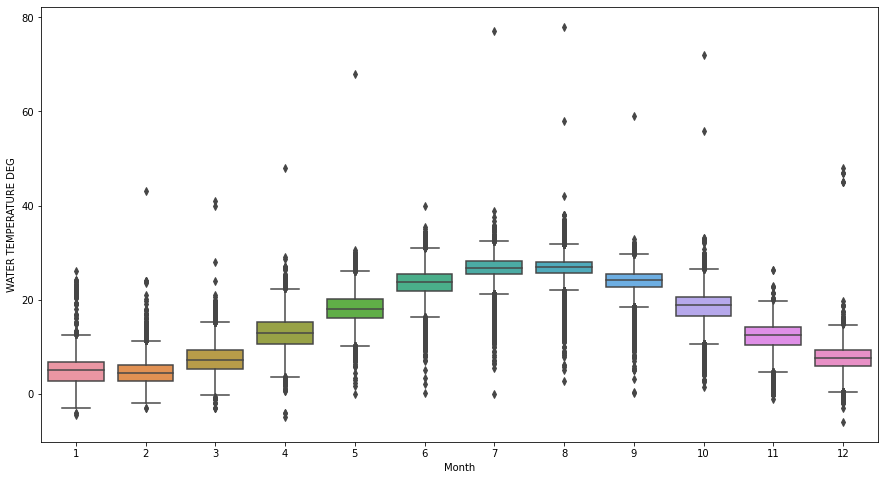

In [20]:
plt.figure(figsize = (15,8))
sns.boxplot(x="Month", y="WATER TEMPERATURE DEG", orient="v", data=month_avg)
    
plt.show()

In [21]:
def create_month_quartile_table(data, column):
    # Creates the quartiles for Celcius values
    prefix = ["Q1", "Q3"]
    suffix = ["_C", "_F"]
    df = data.groupby("Month")[column].describe()[["25%", "75%"]].copy()
    df.columns = [prefix[0], prefix[1]]
    df = pd.concat([df.add_suffix(suffix[0]), (df*9/5+ 32).add_suffix(suffix[1])], axis=1)
    return df


def fix_wrong_temperature_units_values(df, column, table, coef1, coef2):
    """In order for a unit swap to be detected the value must be both outside of range for values within
    assumed unit, but inside of range of alternate unit. Two coeficients that get applied to the IQR
    of each range control the threshold. As units converge, detection automatically becomes more difficult."""
    
    for month in np.arange(1,13):
        q1c, q3c, q1f, q3f = table.loc[month]
        deltac, deltaf = coef1 * (q3c - q1c), coef2 * (q3f-q1f)
        lowc, highc = q1c - deltac, q3c + deltac
        lowf, highf = q1f - deltaf, q3f + deltaf
        conversion = lambda x: (x-32) * 5/9
        df[column] = np.where((df["Month"]==month) & ((df[column]<=lowc) | (df[column]>=highc)) &
                              (df[column]>=lowf) & (df[column]<=highf), conversion(df[column]), df[column])
    return df


def fix_wrong_temperature_units(data, column, coef1, coef2):
    df = data.copy()
    df["Month"] = pd.DatetimeIndex(df["Date"]).month
    stats = create_month_quartile_table(df, column)
    df = fix_wrong_temperature_units_values(df, column, stats, coef1, coef2)
    df.drop(columns=["Month"], inplace=True)
    return df

In [29]:
def clean_cmc_cbp_dataframe(data):
    df = data.copy()
    df["WATER TEMPERATURE DEG"] = np.where(df["WATER TEMPERATURE DEG"] == 1712.00, 17.12, df["WATER TEMPERATURE DEG"])
    df = fix_wrong_temperature_units(df, "WATER TEMPERATURE DEG", 4, 1.5)
    df = fix_wrong_temperature_units(df, "AIR TEMPERATURE DEG", 4, 1.5)
    
    # Aggregating the sample depth data since units have been resolved.
    groups = ["Date", "Station"]
    
    #Takes the median of samples if the datatype is a float (All measured values were). Otherwise takes the first item.
    agg_list = generate_agg_list(df, groups, ["float"], "median", "first")
    df = df.groupby(groups).agg(agg_list).reset_index()
    
    #Removing addtional columns
    df.drop(columns = ['SampleDepth', 'SampleId', 'SampleReplicateType', 'SampleType', "Problem",
                       "Qualifier"], inplace=True)
    return df

In [30]:
df = clean_cmc_cbp_dataframe(df)

In [9]:
df.to_pickle("data/cbp_cmc.pickle")

# Integrating NOAA Data

In [2]:
cbp_cmc_df = pd.read_pickle("data/cbp_cmc.pickle")
noaa_df = pd.read_pickle("data/noaa_match.pickle")
ghcn_df = pd.read_pickle("data/ghcn_match.pickle")
noaa_locations_df = pd.read_pickle("data/noaa_location_key.pickle")
ghcn_locations_df = pd.read_pickle("data/ghcn_location_key.pickle")

To join these dataframes together it makes sense to analyze the time resolution that both of these contain for their observations. It is clear that even with the 100x observation count in the noaa dataframe, they will have to be resampled as these datapoints are spread over different stations. Because of the sparse nature in the CBP/CMC dataframe, there likely won't be much advantage in going more granular than on an hourly level.

(121224, 44)
(5743319, 21)


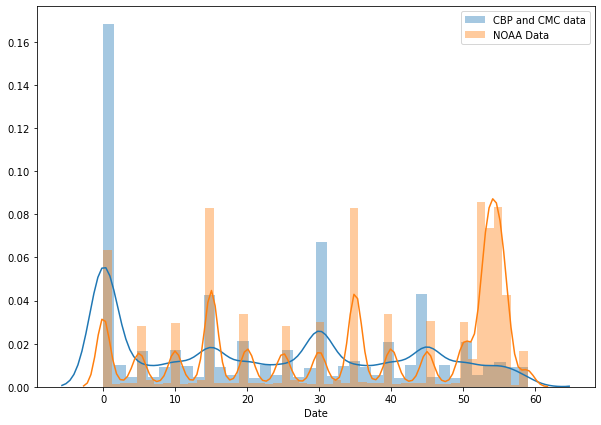

In [3]:
plt.figure(figsize=(10,7))
sns.distplot(cbp_cmc_df["Date"].dt.minute, label="CBP and CMC data")
sns.distplot(noaa_df["Date"].dt.minute, label="NOAA Data")
plt.legend()
print(cbp_cmc_df.shape)
print(noaa_df.shape)
plt.show()

Since the NOAA data contains multiple observations, I leveraged a user created function to change data flagged as suspect to nans. This will allow nonsuspect data to take precedence when flattening to hourly and if it is still present, it will allow the next station neighbor to take precedence when filling na values

In [4]:
noaa_qc = remove_suspect_noaa_data(noaa_df, 'Wind_Dir_Q', ['Wind_Dir', 'Wind_Type'], ["2", "3", "6", "7"])
noaa_qc = remove_suspect_noaa_data(noaa_qc, 'Wind_Speed_Q', ['Wind_Speed'], ["2", "3", "6", "7"])
noaa_qc = remove_suspect_noaa_data(noaa_qc, 'Air Temperature_Q', ['Air Temperature'], ["2", "3", "6", "7"])
noaa_qc = remove_suspect_noaa_data(noaa_qc, 'Air_Pressure_Q', ['Air_Pressure_Q'], ["2", "3", "6", "7"])

In [5]:
noaa_hourly = reduce_time_resolution_in_multindex(noaa_qc, 'Date', "H", ["USAF_ID", "NCEI_WBAN_ID"])
cbp_cmc_hourly = reduce_time_resolution_in_multindex(cbp_cmc_df, 'Date', "H", ["Station"])

In [6]:
# Mapping the degrees to values that can be compared in the correlation matrix.
degree_map = {'N':0, 'E':90, "S":180, "W":270, "NE":45, "SE":135, "SW":225, "NW":315,
              "NNE": 22.5, "ENE": 67.5, "ESE":112.5, "SSE": 157.5, "SSW":202.5, "WSW":247.5, "WNW": 292.5, "NNW":337.5}

# The wind speed is an even less precise conversion.
speed_map = {'1 To 10 Knots':5, '0 To 1 Knot':1, 'Calm':0, '>30 To 40 Knots':35, '20 To 30 Knots':25, '10 To 20 Knots':15, 'Above 40 Knots':45}
meters_second_to_knots = 1.943844

examine_corr_noaa = noaa_hourly[['Date', 'USAF_ID', 'NCEI_WBAN_ID','Wind_Dir', 'Wind_Speed', 'Air Temperature', 'Air_Pressure']].copy()
examine_corr_cbp_cmc = cbp_cmc_hourly[cbp_cmc_hourly['SPECIFIC CONDUCTIVITY'].isna()==False].copy()
examine_corr_cbp_cmc = examine_corr_cbp_cmc[['Date', 'Station', 'WindDirection', 'WindSpeed', 'AIR TEMPERATURE DEG', 'Pressure']]

# Converting the WindDirection to their sin and cosine values to prevent the 0 to 360 degree jump.
examine_corr_cbp_cmc['WindDirection'] = examine_corr_cbp_cmc['WindDirection'].map(degree_map)
examine_corr_cbp_cmc['cmc_wind_sin'] = examine_corr_cbp_cmc['WindDirection'].map(degrees_to_sin)
examine_corr_cbp_cmc['cmc_wind_cos'] = examine_corr_cbp_cmc['WindDirection'].map(degrees_to_cos)
examine_corr_noaa['noaa_wind_sin'] = examine_corr_noaa['Wind_Dir'].map(degrees_to_sin)
examine_corr_noaa['noaa_wind_cos'] = examine_corr_noaa['Wind_Dir'].map(degrees_to_cos)

# A rough categorical to quantitative transformation for the correlation matrix.
examine_corr_cbp_cmc["WindSpeed"] = examine_corr_cbp_cmc["WindSpeed"].map(speed_map)
examine_corr_noaa["Wind_Speed"] = examine_corr_noaa["Wind_Speed"] * meters_second_to_knots

drops = ["Latitude", "Longitude", *noaa_locations_df.columns[5:].to_list()]
examine_corr = examine_corr_cbp_cmc.merge(noaa_locations_df, how="left", on="Station").drop(columns=drops).copy()
#Fixing bug from incompatible datatypes.
examine_corr["WBAN_id1"] = examine_corr["WBAN_id1"].astype("object").map(lambda x: str(x))

#Merging the datasets together and trimming for correlation matrix.
examine_corr = examine_corr.merge(examine_corr_noaa, how="inner", left_on=["Date", "USAF_id1", "WBAN_id1"],
                                  right_on=["Date", 'USAF_ID', 'NCEI_WBAN_ID']).drop(columns=["WindDirection", "Wind_Dir"])

Examining the heatmap, there appears to be a very strong correlation Between the temperature values. The next most significant reading is the wind direction, which considering the categorical values is a strong match.

When restricting to observations with the target variable, there is too little overlap to properly gauge wind speed and pressure. In a previous iteration when the noaa dataframe contained observations for more stations/days, wind speed had a small but significant positive correlation despite the binning and pressure had no clear correlation. I opted the augment the cbp/cmc missing values with closely correlated temperature data from noaa, augment/replace the wind direction depending on distance from the source point, and replace the other columns entirely with the noaa data for the other parameters. The recordings for rainfall were omitted from this correlation matrix since they were both sparse and appeared much less methodological than the NOAA values. They will be replaced entirely as well.

<Figure size 1080x720 with 0 Axes>

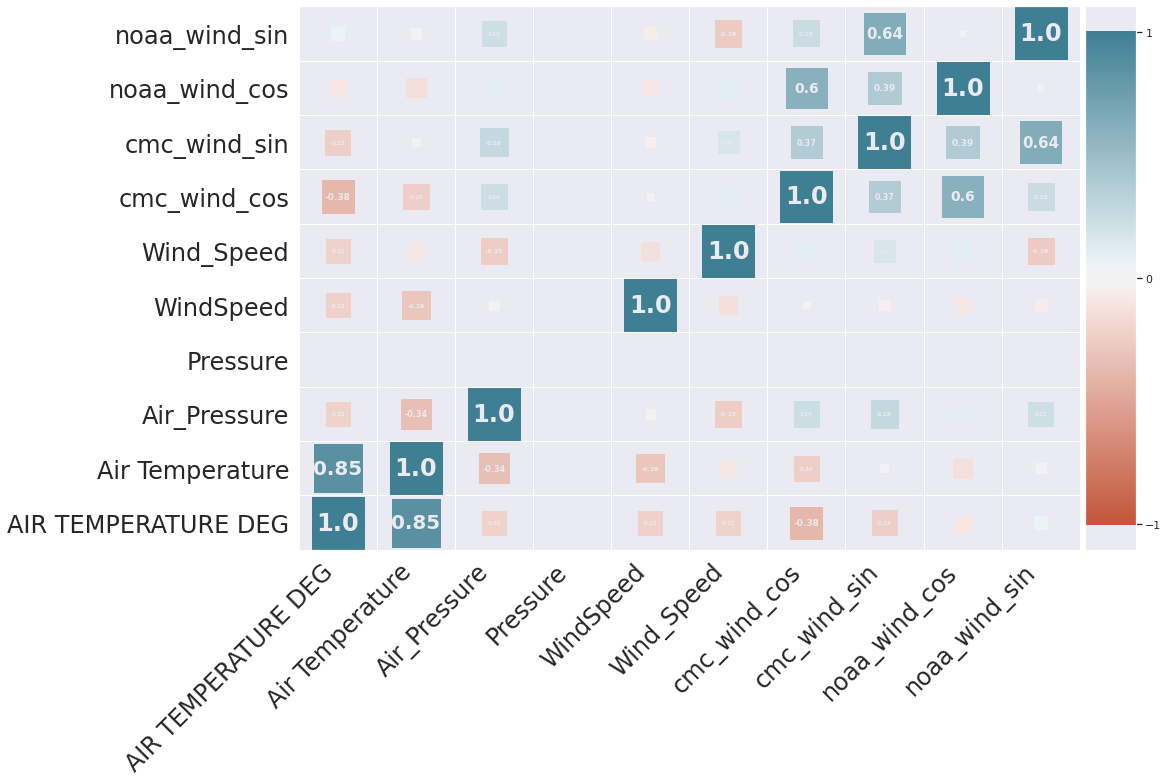

In [7]:
dynamic_heatmap(examine_corr, examine_corr.columns, fontsize=24, annot=True, palette=None, figsize=(15, 10), squaresize=2700)

In [8]:
examine_corr.corr().iloc[0:5,5:]

,Wind_Speed,Air Temperature,Air_Pressure,noaa_wind_sin,noaa_wind_cos
WindSpeed,-0.124601,-0.290469,-0.031175,-0.053134,-0.086193
AIR TEMPERATURE DEG,-0.210534,0.854046,-0.213725,0.060872,-0.095990
Pressure,NaN,NaN,NaN,NaN,NaN
cmc_wind_sin,0.169984,-0.024043,0.280414,0.641831,0.387445
cmc_wind_cos,0.105968,-0.235229,0.237679,0.251705,0.604169


To reduce the amount of observations to those that recorded specific conductivity, I will first try to fill missing information from neighbors (from both databases) within a 5 mile radius. The NOAA neihgbors list can reach distances to almost 60 miles away, so finding any overlapping CBP/CMC points in close proximity first, would provide better accuracy.

In [9]:
cbp_cmc_overlap = cbp_cmc_hourly.groupby("Date").count().reset_index()
cbp_cmc_overlap = cbp_cmc_overlap[(cbp_cmc_overlap["Station"]>1) & (cbp_cmc_overlap["SPECIFIC CONDUCTIVITY"]>0)]["Date"]

cbp_cmc_cond_coords = cbp_cmc_hourly[(cbp_cmc_hourly["Date"].isin(cbp_cmc_overlap)) &
                                     (cbp_cmc_hourly["SPECIFIC CONDUCTIVITY"].isna()==False)][["Station", "Latitude", "Longitude"]]

cbp_cmc_overlap = cbp_cmc_hourly[cbp_cmc_hourly["Date"].isin(cbp_cmc_overlap)]["Station"]
cbp_cmc_all_coords = cbp_cmc_hourly[cbp_cmc_hourly["Station"].isin(cbp_cmc_overlap)][["Station", "Latitude", "Longitude"]]

cbp_cmc_cond_coords = cbp_cmc_cond_coords.groupby("Station").first().reset_index()
cbp_cmc_all_coords = cbp_cmc_all_coords.groupby("Station").first().reset_index()

In [10]:
tree = BallTree(np.deg2rad(cbp_cmc_all_coords[["Latitude", "Longitude"]].values), metric='haversine')

In [11]:
# These stations can be relatively close together. But a high k is necessary because the likelihood of overlapping hours is low.
k = cbp_cmc_all_coords.shape[0]//10
distances, indices = tree.query(np.deg2rad(cbp_cmc_cond_coords[["Latitude", "Longitude"]]), k = k)
indices = pd.DataFrame(indices, columns = [f"Near_Station{i}" for i in np.arange(0,k)])
distances = pd.DataFrame(distances*3959, columns = [f"dist_mi{i}" for i in np.arange(0,k)])

In [12]:
indices = indices.drop(columns="Near_Station0")
distances = distances.drop(columns="dist_mi0")
cbp_cmc_neighbors = cbp_cmc_cond_coords.drop(columns=["Latitude", "Longitude"]).copy()
for i, column in enumerate(indices.columns):
    cbp_cmc_neighbors[column] = indices[column].map(lambda x: cbp_cmc_all_coords["Station"][x])
    cbp_cmc_neighbors["Dist_"+column] = distances[f"dist_mi{i+1}"]

In [13]:
column_list = ['Date', 'Station', 'PrecipType', 'Pressure', 'TideStage', 'Weather Conditions Day Before Yesterday',
               'Weather Conditions Today', 'Weather Conditions Yesterday', 'WindDirection',
               'WindSpeed', 'WATER TEMPERATURE DEG', 'AIR TEMPERATURE DEG']

combined_cbp_cmc_neighbors = cbp_cmc_hourly.merge(cbp_cmc_neighbors, how="left", on="Station").copy()

for i in range(1, k):
    combined_cbp_cmc_neighbors = combined_cbp_cmc_neighbors.merge(cbp_cmc_hourly[column_list], how="left",
                                                                  left_on=["Date", f"Near_Station{i}"], 
                                                                  right_on=["Date", 'Station',], suffixes=(None,i))

In [14]:
cbp_cmc_hourly_self_fill = cbp_cmc_hourly.copy()
for column in column_list:
    if column in ["Date", "Station"]:
        continue
    for i in range(1,k):
        distance_condition = combined_cbp_cmc_neighbors[f"Dist_Near_Station{i}"] < 10
        if distance_condition.all():
            break
        condition = cbp_cmc_hourly_self_fill[column].isna() & distance_condition
        cbp_cmc_hourly_self_fill[column] = np.where(condition, combined_cbp_cmc_neighbors[column+str(i)], cbp_cmc_hourly_self_fill[column])

In [15]:
cbp_cmc_hourly_reduced = cbp_cmc_hourly_self_fill[cbp_cmc_hourly_self_fill['SPECIFIC CONDUCTIVITY'].isna()==False]
dropped_columns = cbp_cmc_hourly_reduced.loc[:,cbp_cmc_hourly_reduced.isna().all()].columns
cbp_cmc_hourly_reduced= cbp_cmc_hourly_reduced.drop(columns=dropped_columns)
print(dropped_columns.tolist(), "are completely empty and will be dropped")

['Agency', 'CloudCover', 'Cruise', 'FieldActivityEventType', 'FlowStage', 'GaugeHeight', 'HUC12', 'Layer', 'LowerPycnocline', 'Method', 'Program', 'Project', 'Sea State', 'Source', 'TotalDepth', 'UpperPycnocline', 'WaveHeight'] are completely empty and will be dropped


In [16]:
k = 12
column_list = ['Date', 'USAF_ID', 'NCEI_WBAN_ID', 'Data Source', 'Latitude', 'Longitude', 'Code', 'Quality_Control',
               'Wind_Dir', 'Wind_Type', 'Wind_Speed', 'Air Temperature', "Air_Pressure"]

# Adds in the locations and distances for the NOAA data.
combined_hourly = cbp_cmc_hourly_reduced.reset_index().merge(noaa_locations_df, how="left", on="Station").copy()

# Adds in the locations and distances for the GHCN data.
combined_hourly = combined_hourly.merge(ghcn_locations_df, how="left", on="Station")


for i in range(1, k+1):
    #Fixing bug from incompatible datatypes.
    combined_hourly[f"WBAN_id{i}"] = combined_hourly[f"WBAN_id{i}"].astype("object").map(lambda x: str(x))
    
    # Making reference columns from the NOAA df
    combined_hourly = combined_hourly.merge(noaa_hourly[column_list], how="left", left_on=["Date", f"USAF_id{i}", f"WBAN_id{i}"],
                                  right_on=["Date", 'USAF_ID', 'NCEI_WBAN_ID'], suffixes=(None,i))
    
    # Making reference columns from the GHCN df
    combined_hourly["Day"] = combined_hourly["Date"].round("D")
    combined_hourly = combined_hourly.merge(ghcn_df, how="left", left_on=["Day", f"ID_{i}"],
                                  right_on=["Date", 'ID'], suffixes=(None,i))
    
combined_hourly = combined_hourly.set_index("index")

In [17]:
def fill_cmc_with_noaa_values(cmc_df, combined_df, cmc_column, noaa_column, k, replace_all=False,
                              max_dist=None, dist_column=None, dist_output_col=None):
    df = cmc_df.copy()
    idx = df.index
    if replace_all:
        df[cmc_column] = pd.Series(np.nan, index=idx)
        
    for i in range(1,k+1):
        
        # Creates the imputing condition depending on whether or not neighbor distances are to be evaluated.
        if dist_column:
            distances = combined_df[dist_column+str(i)]
        if max_dist and dist_column:
            condition = (df[cmc_column].isna()) & (distances <= max_dist)
        else:
            condition = df[cmc_column].isna()
        
        # Imputes values from the reference dataframe depending on the conditions evaluated in the previous block.
        if i == 1:
            neighbor = noaa_column
        else:
            neighbor = noaa_column+str(i)
        df[cmc_column] = np.where(condition, combined_df[neighbor], df[cmc_column])
        
        # If a column to store distances for imputed values is provided, this block will record and track them.
        if dist_output_col:
            output_distances = pandas_series_autocheck(df, dist_output_col, idx)
        if dist_output_col and dist_column:
            df[dist_output_col] = np.where(condition, distances, output_distances)
        elif dist_output_col:
            df[dist_output_col] = np.where(condition, 0.0, output_distances)

    return df

In [18]:
cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_reduced, combined_hourly, 'AIR TEMPERATURE DEG', 'Air Temperature', k, False)

# Prioritizing NOAA Wind Direction Data within 5 miles of the site, then falling back to original data with less precision,
# and finally filling the the rest with NOAA data from further sites.
cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_fill, combined_hourly, 'WindDirection', 'Wind_Dir', k, True, 5,
                                                "noaa_dist_mi", "Wind_Measure_Dist")

converted_wind = combined_hourly['WindDirection'].copy().map(degree_map)
wind_condition = (cbp_cmc_hourly_fill['WindDirection'].isna()) & (converted_wind.isna()==False)
cbp_cmc_hourly_fill['WindDirection'] = np.where(wind_condition, converted_wind, cbp_cmc_hourly_fill['WindDirection'])
cbp_cmc_hourly_fill["Wind_Measure_Dist"] = np.where(wind_condition, 0.0, cbp_cmc_hourly_fill["Wind_Measure_Dist"])
cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_fill, combined_hourly, 'WindDirection', 'Wind_Dir', k, False,
                                                None, "noaa_dist_mi", "Wind_Measure_Dist")

cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_fill, combined_hourly, 'WindSpeed', 'Wind_Speed', k, True)
cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_fill, combined_hourly, 'Pressure', 'Air_Pressure', k, True)

cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_fill, combined_hourly, 'Rainfall', 'PRCP', k, True)
cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_fill, combined_hourly, 'Rainfall Within 24 Hours', 'PRCP_24H', k, True)
cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_fill, combined_hourly, 'Rainfall Within 48 Hours', 'PRCP_48H', k, True)

cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_fill, combined_hourly, 'Snowfall', 'SNOW', k, True)
cbp_cmc_hourly_fill = fill_cmc_with_noaa_values(cbp_cmc_hourly_fill, combined_hourly, 'Snow_Depth', 'SNWD', k, True)
cbp_cmc_hourly_fill = cbp_cmc_hourly_fill.drop(columns=["PrecipType", "Weather Conditions Day Before Yesterday", "Weather Conditions Today",
                                                        "Weather Conditions Yesterday"])

cbp_cmc_hourly_fill = cbp_cmc_hourly_fill.rename(columns={'Rainfall Within 24 Hours':"Rainfaill_24H", 'Rainfall Within 48 Hours':"Rainfaill_48H"})



In [46]:
high_cond_outlier_stations.columns

Index(['Latitude', 'Longitude', 'Pressure', 'Rainfall', 'Rainfaill_24H',
       'Rainfaill_48H', 'WindDirection', 'WindSpeed', 'HUC12_', 'FIPS_',
       'WATER TEMPERATURE DEG', 'SPECIFIC CONDUCTIVITY', 'AIR TEMPERATURE DEG',
       'Wind_Measure_Dist', 'Snowfall', 'Snow_Depth'],
      dtype='object')

/opt/conda/envs/main/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


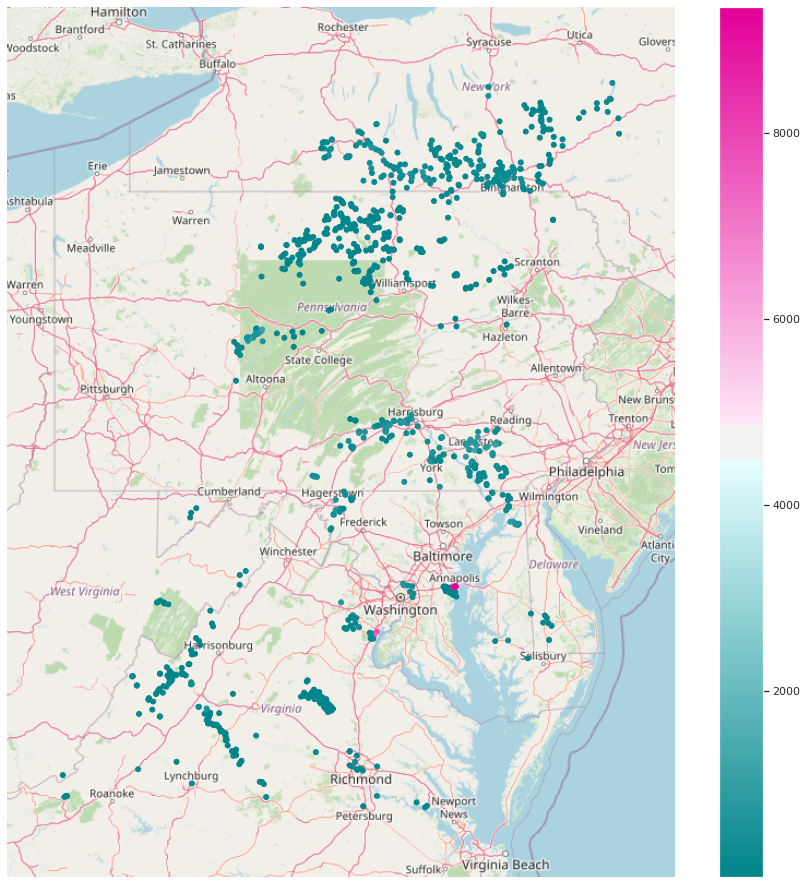

,Station,Date,Database,GroupCode,Latitude,Longitude,Pressure,Rainfall,Rainfaill_24H,Rainfaill_48H,...,Point,HUC12_,HUCNAME_,FIPS_,WATER TEMPERATURE DEG,SPECIFIC CONDUCTIVITY,AIR TEMPERATURE DEG,Wind_Measure_Dist,Snowfall,Snow_Depth
573,PWSWCD.PWSWCD_DQ_PL49_19_CMP32,2020-02-08 00:00:00,CMC,PWSWCD,38.6209,-77.2758,1019.9,10.30,14.75,4.95,...,POINT (-77.2758 38.6209),20700100804,Neabsco Creek,51153,10.75,7887.8,9.6,8.273139,0.0,0.0
576,PWSWCD.PWSWCD_DQ_PL51_19_CMP28,2020-03-14 15:00:00,CMC,PWSWCD,38.5958,-77.2990,1030.4,0.50,0.50,7.60,...,POINT (-77.29899999999998 38.5958),20700110103,Powells Creek,51153,12.40,7387.0,13.9,10.455241,0.0,0.0
586,SCC.EYC,2018-05-03 09:00:00,CMC,SCC,38.9753,-76.4782,1018.4,0.00,0.00,0.00,...,POINT (-76.4782 38.9753),20600040203,Severn River-Frontal Chesapeake Bay,24003,22.30,9050.0,21.1,17.563745,0.0,NaN
587,SCC.HC,2018-05-03 09:00:00,CMC,SCC,38.9678,-76.4971,1017.0,0.15,0.00,0.00,...,POINT (-76.4971 38.9678),20600040203,Severn River-Frontal Chesapeake Bay,24003,23.50,8162.5,21.1,9.513358,0.0,NaN
588,SCC.HW,2018-05-03 09:00:00,CMC,SCC,38.9695,-76.5023,1018.4,0.00,0.00,0.00,...,POINT (-76.50230000000001 38.9695),20600040203,Severn River-Frontal Chesapeake Bay,24003,22.80,8740.0,21.1,17.109370,0.0,NaN
589,SCC.MAC,2018-05-03 08:00:00,CMC,SCC,38.9732,-76.4924,1018.2,0.00,0.00,0.00,...,POINT (-76.4924 38.9732),20600040203,Severn River-Frontal Chesapeake Bay,24003,22.30,9100.0,21.1,1.243421,0.0,NaN
590,SCC.MOS,2018-05-03 10:00:00,CMC,SCC,38.9753,-76.4837,1019.2,0.00,0.00,0.00,...,POINT (-76.4837 38.9753),20600040203,Severn River-Frontal Chesapeake Bay,24003,21.20,9310.0,21.1,17.379817,0.0,NaN
591,SCC.MOWC,2018-05-03 09:00:00,CMC,SCC,38.9724,-76.4958,1018.4,0.00,0.00,0.00,...,POINT (-76.4958 38.9724),20600040203,Severn River-Frontal Chesapeake Bay,24003,23.00,8770.0,21.1,17.147895,0.0,NaN
592,SCC.MSM,2018-05-03 09:00:00,CMC,SCC,38.9699,-76.4996,1018.4,0.00,0.00,0.00,...,POINT (-76.4996 38.9699),20600040203,Severn River-Frontal Chesapeake Bay,24003,22.80,8740.0,21.1,1.565191,0.0,NaN
593,SCC.MSW,2018-05-03 09:00:00,CMC,SCC,38.9734,-76.4879,1018.4,0.00,0.00,0.00,...,POINT (-76.4879 38.9734),20600040203,Severn River-Frontal Chesapeake Bay,24003,22.00,8770.0,21.1,17.345732,0.0,NaN


In [48]:
agg_list = generate_agg_list(cbp_cmc_hourly_fill, ["Station"], ["float"], "median", "first")
high_cond_outlier_stations = cbp_cmc_hourly_fill.groupby("Station").agg(agg_list).reset_index()
geometry = high_cond_outlier_stations['Point'].apply(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(high_cond_outlier_stations[["SPECIFIC CONDUCTIVITY"]], crs=crs, geometry=geometry)
ax = gplt.webmap(gdf, figsize = (16, 16), projection=gcrs.WebMercator())
gplt.pointplot(gdf, hue= "SPECIFIC CONDUCTIVITY", ax=ax, legend = 'True', cmap=sns.diverging_palette(200, 340, s=100, as_cmap=True))
plt.show()
high_cond_outlier_stations[high_cond_outlier_stations["SPECIFIC CONDUCTIVITY"]>5000]

There are two regions that stand out in terms of conductivity highs. The major one is made up of the same stations (with the scc prefix) that previously was measured in different units and was on a different scale. It appears the locations for those observations are at Annapolis Harbor and their location indicates that they will be subject to much more salinity than the rest of the data, skewing the conductivity predictions. Those stations will be dropped from the DataFrame.

In [64]:
cbp_cmc_hourly_fill = cbp_cmc_hourly_fill[cbp_cmc_hourly_fill["Station"].isin(["SCC.EYC", "SCC.HC", "SCC.HW", "SCC.MAC", "SCC.MOS",
                                                                               "SCC.MOWC", "SCC.MSM", "SCC.MSW", "SCC.SUP"])==False]

In [66]:
conditions = ((cbp_cmc_hourly_fill["WATER TEMPERATURE DEG"].isna()==False) & (cbp_cmc_hourly_fill["WindDirection"].isna()==False) &
              (cbp_cmc_hourly_fill["Pressure"].isna()==False) & (cbp_cmc_hourly_fill["Rainfaill_24H"].isna()==False) &
              (cbp_cmc_hourly_fill["Rainfaill_48H"].isna()==False) & (cbp_cmc_hourly_fill["Snowfall"].isna()==False))
working_df = cbp_cmc_hourly_fill[conditions]

In [67]:
working_df = convert_to_wind_velocity(working_df, "WindDirection", "WindSpeed")
working_df = working_df.dropna(axis=1)

In [69]:
working_df.to_pickle("data/test.pickle")

In [24]:
working_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11452 entries, 0 to 117948
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   11452 non-null  datetime64[ns]
 1   Station                11452 non-null  object        
 2   Database               11452 non-null  object        
 3   GroupCode              11452 non-null  object        
 4   Latitude               11452 non-null  float64       
 5   Longitude              11452 non-null  float64       
 6   Pressure               11452 non-null  float64       
 7   Rainfall               11452 non-null  float64       
 8   Rainfaill_24H          11452 non-null  float64       
 9   Rainfaill_48H          11452 non-null  float64       
 10  TierLevel              11452 non-null  object        
 11  Point                  11452 non-null  object        
 12  HUC12_                 11452 non-null  int64         
 13  

In [25]:
working_df[working_df["Snow_Depth"].isna()]

KeyError: 'Snow_Depth'